<a href="https://colab.research.google.com/github/snyamson/LP5-Twitter-Sentiment-Analysis/blob/main/LP_5_DistilBERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

The COVID-19 pandemic has not only brought about unprecedented global health challenges but has also sparked a flood of public discourse on social media platforms, especially Twitter. People from around the world use Twitter to express their thoughts, emotions, and opinions regarding the pandemic, including their sentiments about various aspects of it, such as vaccines, government responses, and personal experiences.

Understanding this sentiment on a large scale can provide valuable insights into public perceptions, concerns, and attitudes surrounding COVID-19. This is where the "COVID-19 Twitter Sentiment Analyzer" project comes into play. This project leverages state-of-the-art deep learning models and natural language processing techniques to systematically analyze and categorize the sentiment expressed in a vast collection of COVID-19-related tweets.

# BUSINESS UNDERSTANDING

Ultimately, the "COVID-19 Twitter Sentiment Analyzer" project aligns with the broader goal of leveraging technology to enhance our understanding of public sentiment during a global health crisis. By providing actionable insights and promoting responsible social media discourse, this project serves as a valuable resource for organizations, researchers, and decision-makers seeking to navigate the complex landscape of public opinion in these challenging times.

# INSTALLATIONS

In [ ]:
# Install required dependencies
!pip install -q datasets transformers huggingface_hub accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00


# IMPORTATION

In [ ]:
# Load necessary libraries
import os
import re
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Google drive
from google.colab import drive

# Deep learning
import torch
from torch import nn

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Class imbalance
from sklearn.utils.class_weight import compute_class_weight

# Dataset preparation
from datasets import load_dataset, load_metric

# Transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding

# Huggingface
from huggingface_hub import notebook_login

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check if GPU is available
torch.cuda.is_available()

True

In [ ]:
# Set random seeds for PyTorch
seed = 12
torch.manual_seed(seed)

# Further set seeds for GPU operations if using CUDA
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)


# DATA LOADING

In [ ]:
# Mount the google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Navigate to the Colab Notebooks / data folder
%cd drive/MyDrive/"Colab Notebooks"/data

/content/drive/MyDrive/Colab Notebooks/data


In [ ]:
# Load both train and test dataset
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Test.csv')

# DATA UNDERSTANDING AND EDA

In [ ]:
# Inspect the first 5 rows of the train set
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
# Inspect the last 5 rows of the train set
train.tail()

,tweet_id,safe_text,label,agreement
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000
10000,P6190L3Q,Pneumonia vaccine: for women w risk of pulmona...,1.0,0.666667


In [ ]:
# Inspect the first 5 rows of the test set
test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [ ]:
# Inspect the last 5 rows of the test set
test.tail()

,tweet_id,safe_text
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...
5174,ZYITEHAH,<user> issues alert regarding Measles in TX. K...
5175,ZZ3BMBTG,I can't believe people don't vaccinate their k...
5176,ZZIYCVNH,"""<user> Alternatives to #Flu Vaccine <url> #n..."


In [ ]:
# Get the number of rows and columns from the train set
train.shape

(10001, 4)

In [ ]:
# Get the number of rows and columns from the test set
test.shape

(5177, 2)

In [ ]:
# Get more information on both train and test set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [ ]:
# Check for missing values
train.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [ ]:
test.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [ ]:
# Check for duplicates
train.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

In [ ]:
# Check for labels distribution
train['label'].value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

In [ ]:
# Check for data quality
train['safe_text'].sample(10)

4242    Gilroy Costco Says Shoppers May Have Been Expo...
7266       <user> a Franchise Professional Hit #MMR <url>
6473    In Somalia, a wives' tale delays measles treat...
9981    MSNBC, you bastards,you got me. Headline read:...
2759    Just Got Vaccinated Since Bitches Got Baby Fev...
912              Measles everywhere RT <user> <url> <url>
3714    <user> <user> U can choose not to vaccinate ur...
1482    #Ebola With Ebola waning, attention turns to c...
5005    Anti-vaxx insanity: A recent measles outbreak ...
1555    Jennifair on Trill Radio #SINS EP coming soon....
Name: safe_text, dtype: object

# DATA QUALITY ISSUES

1.   The label and the agreement columns contains missing values.
2.   The safe_text column contains inconsistent use of HTML entities like "<user>" instead of actual user mentions (e.g., "@username"), which complicates text preprocessing and analysis.
3.   The safe_text column contains rows which have some excessive spaces, leading or trailing spaces, or multiple consecutive spaces, as they can affect the accuracy of text analysis and model performance.





# DATA CLEANING

### CLEAN TEXT

In [ ]:
# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'<user>', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
# Apply the clean_text function to the 'safe_text' column
train['safe_text'] = train['safe_text'].apply(clean_text)

In [ ]:
# Confirm changes
train['safe_text'].sample(10)

3622     My mom had measles as child b vaccine was ava...
7256     and a poorly educated populous makes stupid d...
9238    I Honestly think the Government let ebola into...
7534        Vaccinate fat kids hahahaha  ScandalABC TGIT 
7031    All California schools have been advised to cl...
1163    Outbreak of  measles cases linked to Disneylan...
9449    TODAY at  am The FL Dept of Health will open i...
7117                                        que se yo mmr
1770    The less people the easier it is to control it...
4654                             Medicinal poison Vaccine
Name: safe_text, dtype: object

### REMOVE WHITE SPACES

In [ ]:
# Function to remove extra white spaces
def remove_extra_spaces(text):
   # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
# Apply the remove_extra_spaces function to the 'safe_text' column
train['safe_text'] = train['safe_text'].apply(remove_extra_spaces)

In [ ]:
# Confirm changes
train['safe_text'].sample(10)

8954                   states have the measles virus OMG 
2615    Australia deals blow to the AntiVax movement s...
9493    FYI a flu shot does not protect you from measl...
5495     CDC Highest number of US measles cases since ...
3639    This is scary How many people arent vaccinatin...
3588    Europe is big threat to resurgence of measles ...
347     Health district possible measles cases reporte...
8367    Oh great now the American healthcare system is...
4147    CDC says flu shot less effective while health ...
5780     right Like if it were true a lot more kids wo...
Name: safe_text, dtype: object

### REMOVE MISSING VALUES

In [ ]:
# Drop all missing values
train.dropna(inplace=True)

In [ ]:
# Confirm changes
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

# TEXT ANALYSIS

### WORD CLOUDS

To visualize the most common words in positive, negative, and neutral tweets using word clouds


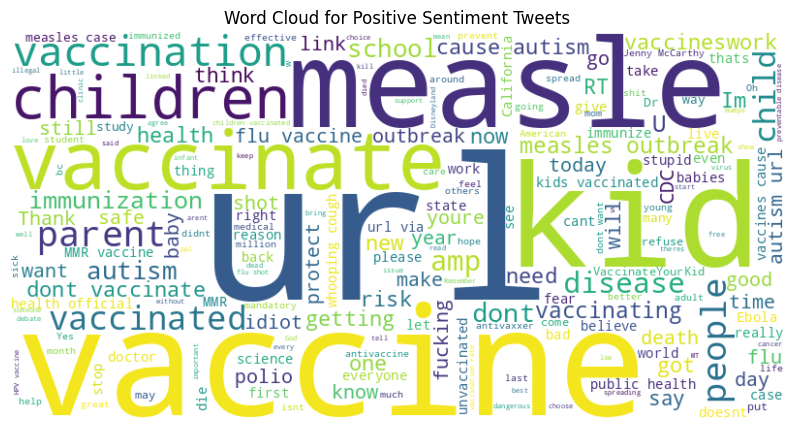

In [ ]:
# Extract positive sentiment tweets
positive_tweets = train[train['label'] == 1]['safe_text']

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))

# Set the fig size
plt.figure(figsize=(10, 6))

plt.imshow(wordcloud, interpolation='bilinear')

# Set Axis off
plt.axis('off')

# Set plot title
plt.title('Word Cloud for Positive Sentiment Tweets')

# Show plot
plt.show()

The word cloud provides a visual representation of the most frequent terms in the dataset. The size of each word in the cloud is proportional to its frequency.

*   Notably, terms related to vaccination and health issues, such as "vaccine","vaccination," "child," and "measles," are prevalent, indicating the central focus of the dataset.
*   Some terms are associated with concerns or misconceptions about vaccines, like "autism," "vaccines cause," and "immunization."
*   The appearance of certain Twitter-related terms (e.g., "RT" for retweet) highlights the influence of social media in discussions about vaccination.

It's evident that the word cloud can serve as a useful tool for quickly identifying key topics and terms in your text data, aiding in your sentiment analysis.

### DISTRIBUTION OF TEXT LENGHTS

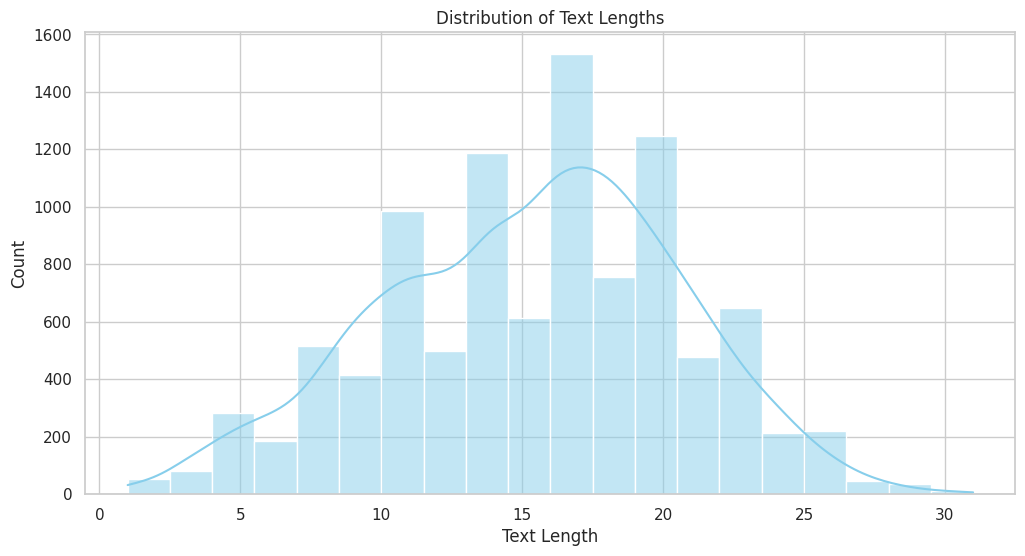

In [ ]:
# Calculate text lengths (the number of words) in the 'safe_text' column
text_lengths = train['safe_text'].apply(lambda x: len(x.split()))

# Set the style for Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Using sns.histplot to create a histogram with Seaborn
sns.histplot(text_lengths, bins=20, kde=True, color="skyblue")

plt.title('Distribution of Text Lengths')  # Set the plot title

plt.xlabel('Text Length')  # Label for the x-axis

plt.ylabel('Count')  # Label for the y-axis

plt.show()  # Display the plot


The histogram of text lengths represents the distribution of the number of words in the text data. Each bar on the histogram corresponds to a range of text lengths, and the height of each bar represents the number of tweets falling into that range.

Looking at the histogram, we can observe that most tweets have a text length in the range of approximately 10 to 30 words.

The histogram provides a visual summary of the distribution of text lengths, helping to identify the typical text length and the presence of any unusual or extreme cases. This information can be valuable when setting the maximum sequence length for text processing in the sentiment analysis model.

### SENTIMENT LABEL DISTRIBUTION

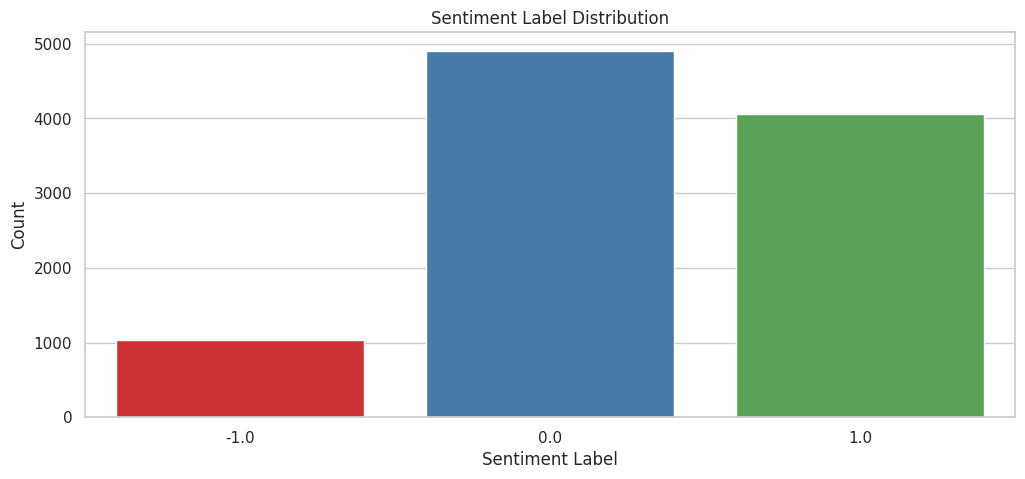

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 5))

sns.countplot(data=train, x='label', palette="Set1")

plt.title('Sentiment Label Distribution')  # Set the plot title

plt.xlabel('Sentiment Label')  # Label for the x-axis

plt.ylabel('Count')  # Label for the y-axis

plt.show()  # Display the plot


The count plot visually represents the distribution of sentiment labels in the dataset. In the dataset, sentiment labels are categorized as follows:

- Neutral (0.0): Represented by the blue bar, with 4908 occurrences.
- Positive (1.0): Represented by the green bar, with 4053 occurrences.
- Negative (-1.0): Represented by the red bar, with 1038 occurrences.

The height of each bar corresponds to the count of tweets associated with a specific sentiment label.

This plot provides a clear overview of the sentiment distribution, highlighting that neutral and positive sentiments are more prevalent, while negative sentiments are relatively less frequent in the dataset.


# DATA PREPROCESSING

### TRAIN VALIDATION SPLIT

In [ ]:
# perform a train validation split with 20% validation set size
X_train, X_val = train_test_split(train, test_size=0.2, random_state=12, stratify=train['label'])

In [ ]:
# Check the number of rows and columns
X_train.shape, X_val.shape

((7999, 4), (2000, 4))

In [ ]:
# Save the training and validation set for reproducibility
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/data/training_set.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Colab Notebooks/data/validation_set.csv', index=False)

### PREPARE DATASETS

In [ ]:
# Load the train and val dataset using the load_data function from datasets
data = load_dataset(path='csv', name='sentiment_analysis_data', data_files={
    'train': '/content/drive/MyDrive/Colab Notebooks/data/training_set.csv',
    'val': '/content/drive/MyDrive/Colab Notebooks/data/validation_set.csv'
},)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

In [ ]:
# Confirm successful data loading
data

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement'],
        num_rows: 7999
    })
    val: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement'],
        num_rows: 2000
    })
})

In [ ]:
# Transform the labels

def transform_labels(label):

      label = label['label']
      num = 0
      if label == -1: # Negative Sentiment
          num = 0
      elif label == 0: # Neutral Sentiment
          num = 1
      elif label == 1: # Positive Sentiment
          num = 2

      return {'labels': num}

In [ ]:
# Define the model name to be used for tokenization and modeling
MODEL_NAME = f"distilbert-base-uncased-finetuned-sst-2-english"

In [ ]:
# Create an instance of the tokenizer from the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Function to tokenize data
def tokenize_data(data):
    return tokenizer(data['safe_text'], padding='max_length', max_length = 256)

In [ ]:
# Tokenize the tweets
dataset = data.map(tokenize_data, batched=True)

# Transform	labels and limit the columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Print out the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

### DATASET FEATURES EXPLANATION


1. **input_ids:**
   - `input_ids` represent the input to a natural language processing (NLP) model in the form of tokenized and numerical values.
   - These are the tokenized versions of the text data, where words and tokens are converted to unique numerical identifiers.
   - These numerical values enable the model to understand and process the text data, making it suitable for machine learning algorithms.

2. **attention_mask:**
   - `attention_mask` is a companion to `input_ids` and is used to indicate which parts of the input sequence should be attended to by the model and which parts should be ignored.
   - The attention mask is important for maintaining the structure and integrity of the input data while accommodating variations in text length.

3. **labels:**
   - `labels` refer to the target values that the model is trying to predict.
   - These are '1' for neutral, '2' for positive, and '0' for negative sentiment.

# HANDLE CLASS IMBALANCE

### THE INVERSE CLASS FREQUENCY METHOD
This method involves assigning weights to classes based on the inverse of their frequencies, with the goal of giving more importance to underrepresented classes.

**Mathematical Explanation:**
1. First, count the number of samples in each class. Let's denote these counts as `n_class_0`, `n_class_1`, `n_class_2`, and so on, for each class.

2. The class weight for each class is calculated as the inverse of its frequency. This means you take the total number of samples and divide it by the number of samples in that class. The formula for the class weight for class `i` is:

   **Class Weight (i) = Total Number of Samples / Number of Samples in Class i**

   Mathematically:
   **Class Weight (i) = N / n_class_i**

   Where:
   - `Class Weight (i)` is the weight assigned to class `i`.
   - `Total Number of Samples` is the total number of samples in the dataset.
   - `n_class_i` is the number of samples in class `i`.

3. The goal is to make the class weights inversely proportional to the class frequencies. This means that classes with fewer samples will have higher weights, while classes with more samples will have lower weights.

### IMPLEMENTATION

In [ ]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

In [ ]:
# Preview class weights
class_weights, np.unique(labels)

(array([3.20858404, 0.67914756, 0.82243471]), array([0, 1, 2]))

The weights calculated will be used during training to give different levels of importance to each class based on their imbalance in the dataset.

The Weights assigned are as follows:

*   Class 0 (Negative Sentiment) is assigned a weight of approximately 3.21.
*   Class 1 (Neutral Sentiment) is assigned a weight of approximately 0.68.
*   Class 2 (Positive Sentiment) is assigned a weight of approximately 0.82


The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.







# FINE-TUNING

### MODEL USED

distilbert-base-uncased-finetuned-sst-2-english

This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2. This model reaches an accuracy of 91.3 on the dev set (for comparison, Bert bert-base-uncased version reaches an accuracy of 92.7).

[Model Link on Huggingface](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

In [ ]:
# Define an instance of the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments with 5 epochs
training_args = TrainingArguments(
    "distilbert_covid_tweets_sentiment_analysis_model_trainer",
    num_train_epochs=3,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_strategy="steps"
    )

In [ ]:
# Define evaluation metrics
metric = load_metric("accuracy")

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Instantiate the training and validation sets with random state of 12
train_dataset = dataset["train"].shuffle(seed=12)
val_dataset = dataset["val"].shuffle(seed=12)

In [ ]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator_with_padding = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=256, return_tensors="pt")

In [ ]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer = tokenizer,
                  data_collator=data_collator_with_padding,
                  compute_metrics=compute_metrics,
)

In [ ]:
# Apply the trainer for training
c_trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.899400,0.769895,0.699000
1000,0.796300,0.733580,0.733000
1500,0.611100,0.839721,0.743500
2000,0.618100,0.787558,0.754500
2500,0.424500,1.023667,0.758500
3000,0.363800,1.057999,0.758500


TrainOutput(global_step=3000, training_loss=0.6188931020100912, metrics={'train_runtime': 666.9621, 'train_samples_per_second': 35.98, 'train_steps_per_second': 4.498, 'total_flos': 1589438427646464.0, 'train_loss': 0.6188931020100912, 'epoch': 3.0})

- `Training Loss:` The training loss is decreasing with each step, which is a positive sign. It suggests that the model is learning and improving its predictions on the training data.

- `Validation Loss:` The validation loss is relatively stable for the first few steps but starts to increase after the third step. This could indicate overfitting, where the model is performing well on the training data but not generalizing as effectively to unseen data.

- `Accuracy:` The accuracy on the validation data is around 76% in the fourth and final step, which is a reasonable accuracy. The model is correctly predicting sentiments for approximately 76% of the validation samples.

### PLOT OF TRAINING EVALUATIONS

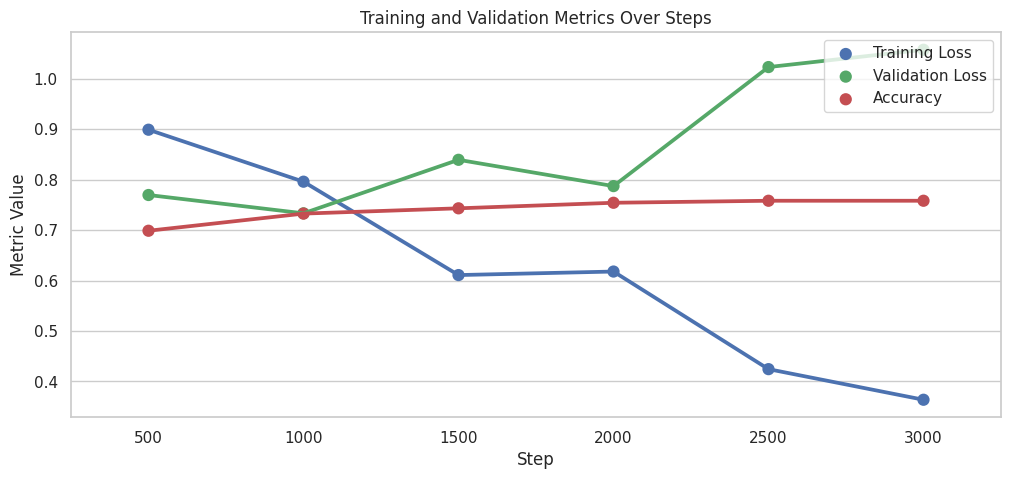

In [ ]:
# Create a DataFrame from the training evaluations
data = pd.DataFrame({
    'Step': [500, 1000, 1500, 2000, 2500, 3000],
    'Training Loss': [0.899400, 0.796300, 0.611100, 0.618100, 0.424500, 0.363800],
    'Validation Loss': [0.769895, 0.733580, 0.839721, 0.787558, 1.023667, 1.057999],
    'Accuracy': [0.699000, 0.733000, 0.743500, 0.754500, 0.758500, 0.758500]
})

# Set the style for Seaborn (optional, for visual customization)
sns.set(style="whitegrid")

# Create a point plot using Seaborn
plt.figure(figsize=(12, 5))
sns.pointplot(data=data, x='Step', y='Training Loss', color='b', label='Training Loss')
sns.pointplot(data=data, x='Step', y='Validation Loss', color='g', label='Validation Loss')
sns.pointplot(data=data, x='Step', y='Accuracy', color='r', label='Accuracy')

plt.title('Training and Validation Metrics Over Steps')
plt.xlabel('Step')
plt.ylabel('Metric Value')
plt.legend(loc='upper right')
plt.show()

### PERFORM EVALUATION USING THE VALIDATION SET

In [ ]:
# Perform evaluation with the same trainer instance
evaluation_output = c_trainer.evaluate()

In [ ]:
# Print the evaluation output
evaluation_output

{'eval_loss': 0.7335801720619202,
 'eval_accuracy': 0.733,
 'eval_runtime': 16.0538,
 'eval_samples_per_second': 124.581,
 'eval_steps_per_second': 15.573,
 'epoch': 3.0}

The metrics above provide insights into the model's performance, efficiency, and how well it's generalizing to the validation data. An accuracy of 73.3% suggests that the model is correctly classifying sentiments for a significant portion of the validation samples.

The loss value of 0.733 represents the model's error in making predictions on the validation data, where a lower value indicates better performance.

Additionally, the evaluation runtime, samples processed per second, and steps processed per second gives an idea of how quickly the model can make predictions, which is crucial in real-time applications.

# PUSH MODEL TO HUGGINGFACE

In [ ]:
# Login to hugginface
notebook_login()

In [ ]:
# Push model and tokenizer to HF Hub
model.push_to_hub("snyamson/covid-tweet-sentiment-analyzer-distilbert")
tokenizer.push_to_hub("snyamson/covid-tweet-sentiment-analyzer-distilbert")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/snyamson/covid-tweet-sentiment-analyzer-distilbert/commit/f586f003c31a6fad562f6a61201b2dbd5ffbecf4', commit_message='Upload tokenizer', commit_description='', oid='f586f003c31a6fad562f6a61201b2dbd5ffbecf4', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Push the dataset to the Hugging Face Hub
dataset.push_to_hub("snyamson/covid-tweet-sentiment-analyzer-distilbert-data")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
# Requirements.txt file
!pip freeze > requiremets.txt